<a href="https://colab.research.google.com/github/khushee-g/EEG/blob/main/Improving_Random_Forest_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load in Data

In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as a dataframe
features = pd.read_csv('/content/Sheet 1-1-EEG.psychiatric control & behvaior.csv')

# Data Preparation

In [2]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['specific_disorder']
features = features.drop('specific_disorder', axis = 1)

### Restrict to the Most Important Features

These were the six features required to reach a total feature importance of 95% in the first improving random forest notebook.
We will use only these features in order to speed up the model.

In [3]:
# Names of six features accounting for 95% of total importance
important_feature_names = features.columns[8:].tolist()


features = features[important_feature_names]
features.head(5)

,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,AB.A.delta.k.C4,AB.A.delta.l.T4,AB.A.delta.m.T5,AB.A.delta.n.P3,...,eeg.date_2018.9.20,eeg.date_2019.1.8,eeg.date_2019.2.14,eeg.date_2019.2.23,eeg.date_2019.2.28,eeg.date_2019.3.22,eeg.date_2019.3.7,eeg.date_2019.6.11,main_disorder_4,main_disorder_Addictive disorder
0,69.447900,69.042085,57.324333,41.658465,55.851042,56.265661,53.905350,42.953339,20.835076,39.310861,...,False,False,False,False,False,False,False,False,True,False
1,22.461115,23.616729,50.770251,14.458573,13.843582,19.761720,17.926815,18.240048,5.551248,13.156196,...,False,False,False,False,False,False,False,False,True,False
2,16.792161,16.887329,27.237218,10.324034,16.298826,19.518705,17.802851,14.068761,7.938156,12.294077,...,False,False,False,False,False,False,False,False,True,False
3,17.029861,13.545934,11.612536,13.578299,13.790407,14.739175,13.077751,8.364132,12.401455,11.919676,...,False,False,False,False,False,False,False,False,True,False
4,26.128217,26.002065,16.649180,7.972443,24.789548,21.259534,18.664022,13.062918,8.586322,12.832026,...,False,False,False,False,False,False,False,False,True,False


In [4]:
labels[1:6]

,specific_disorder
1,4
2,4
3,4
4,4
5,4


In [5]:
# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size = 0.25, random_state = 42)

In [6]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (141, 416)
Training Labels Shape: (141,)
Testing Features Shape: (47, 416)
Testing Labels Shape: (47,)


### Examine the Default Random Forest to Determine Parameters

We will use these parameters as a starting point. I relied on the [sklearn random forest documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to determine which features to change and the available options.

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Search with Cross Validation

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_labels);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
123 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

In [11]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [12]:
rf_random.cv_results_

{'mean_fit_time': array([1.90766772e+00, 5.33578881e+00, 2.95812829e+00, 3.40167681e-03,
        9.23552362e+00, 3.26091758e+00, 3.28485950e+00, 1.35257045e+00,
        3.15197309e-03, 1.09195709e-03, 1.30375226e-03, 2.64054052e+00,
        4.33877881e+00, 3.45584734e+00, 2.77538912e+00, 1.27911568e-03,
        5.03420830e-03, 2.61208057e+00, 3.04373105e-03, 2.10404396e-03,
        3.87681667e+00, 4.83780265e+00, 3.31232500e+00, 2.60066986e-03,
        4.06518650e+00, 1.14056603e+00, 1.02639198e-03, 2.44722581e+00,
        9.82284546e-04, 2.93763200e+00, 3.73559650e+00, 1.73203818e+00,
        1.60067447e+00, 1.90869649e+00, 6.00532230e+00, 1.65522877e+00,
        3.09359487e+00, 2.75270144e-03, 9.94920731e-04, 4.18621023e+00,
        1.00882848e-03, 2.08356524e+00, 1.90724087e+00, 9.66357787e-01,
        9.72032547e-04, 3.64231491e+00, 3.48536174e-03, 1.06446346e+00,
        2.30344454e+00, 1.42483107e+00, 1.10912323e-03, 7.34663010e-03,
        1.03370349e-03, 4.05152639e-03, 4.05030

## Evaluation Function

In [13]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

#### Evaluate the Default Model

In [14]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

Model Performance
Average Error: 0.0000 degrees.
Accuracy = 100.00%.


#### Evaluate the Best Random Search Model

In [15]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 0.2724 degrees.
Accuracy = 93.92%.


In [16]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -6.08%.


# Grid Search

We can now perform grid search building on the result from the random search.
We will test a range of hyperparameters around the best values returned by random search.

In [21]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': [2,3],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [400]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [22]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [23]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

#### Evaluate the Best Model from Grid Search

In [24]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Model Performance
Average Error: 0.4166 degrees.
Accuracy = 90.64%.


In [25]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of -9.36%.


## Another Round of Grid Search

In [26]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid,
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [ ]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 75}

In [ ]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

Model Performance
Average Error: 0.4490 degrees.
Accuracy = 89.92%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_final_accuracy - base_accuracy) / base_accuracy))

Improvement of -10.08%.


A very slight improvement in accuracy means we have reached the point of diminishing returns from tuning. We will stop here and use this as our final model.

## Final Model

The final model from hyperparameter tuning is as follows.

In [57]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, test_features, test_labels)

Final Model Parameters:

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 0.4166 degrees.
Accuracy = 90.64%.


## Comparison of All Improvement Techniques

Finally, we can make comparisons between the improvement techniques to determine which ones were most effective.

In [27]:
# Time used for evaluating model run times
import time

In [28]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]

    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))

        end_time = time.time()
        run_times.append(end_time - start_time)

    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)

    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape

    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    print(results)


### Random Search Best Model

In [29]:
random_results = evaluate_model(best_random, train_features, train_labels, test_features, test_labels)

{'time': 0.8338524103164673, 'error': 0.27244680851063846, 'accuracy': 93.91968085106383, 'n_trees': 400, 'n_features': 416}


In [43]:
original_features = pd.read_csv('/content/Sheet 1-1-EEG.psychiatric control & behvaior.csv')
original_features = pd.get_dummies(original_features)

original_labels = np.array(original_features['specific_disorder'])
original_features= original_features.drop('specific_disorder', axis = 1)

original_feature_list = list(original_features.columns)
original_features = np.array(original_features)

original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(original_features, original_labels, test_size = 0.25, random_state = 42)

# Need to keep only those features the one year model was trained on
one_test_features = full_features_test[original_feature_list]
one_test_features = np.array(one_test_features)

full_labels_test = np.array(full_labels_test)

# Default model
rf = RandomForestRegressor(n_estimators= 10, random_state=42)

# Results for model trained on one year of data


In [45]:
random_results

### First Grid Search Best Model

In [47]:
first_grid_results = evaluate_model(best_grid, train_features, train_labels, test_features, test_labels)


{'time': 0.5647247314453125, 'error': 0.4166489361702128, 'accuracy': 90.63962765957447, 'n_trees': 400, 'n_features': 416}


In [48]:
first_grid_results

### Second Grid Search Best Model

# Comparison

## Plotting

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

### Model Comparison Plot

TypeError: list indices must be integers or slices, not str

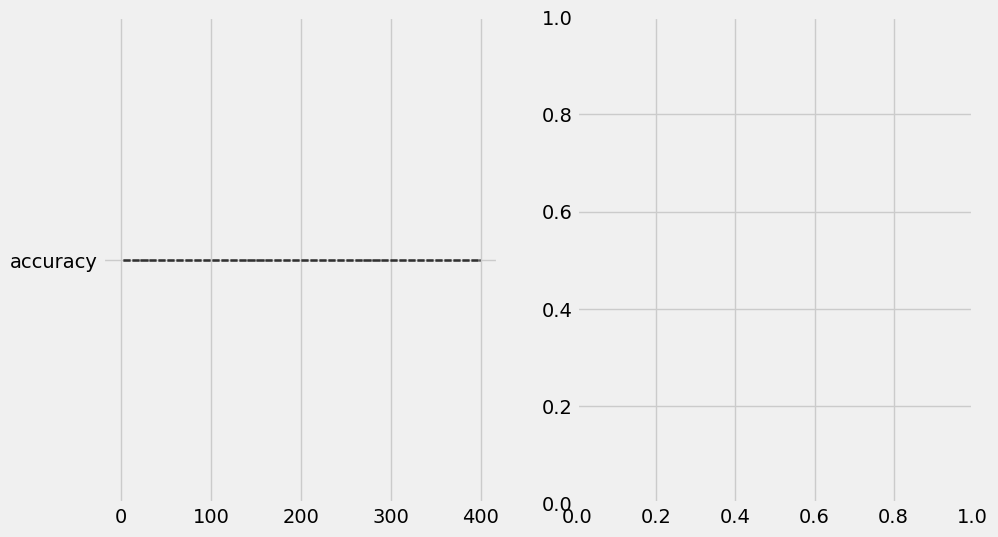

In [58]:
xvalues = list(range(len(final_model)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, ['accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, final_model['model'], rotation = 45, fontsize = 12)
plt.ylim(ymin = 91, ymax = 94)
plt.xlabel('model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(122)
plt.bar(xvalues, final_model['error'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, final_model['model'], rotation = 45)
plt.ylim(ymin = 3.5, ymax = 4.8)
plt.xlabel('model'); plt.ylabel('Error (deg)'); plt.title('Error Comparison');
plt.show();

# Training Curves

We can perform grid search over only one parameter to observe the effects of changing that parameter on performance. We will look at training time, training set accuracy, and testing set accuracy.

#### Number of Trees

In [64]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error', return_train_score=True)
tree_grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [65]:
tree_grid_search.cv_results_

{'mean_fit_time': array([0.01608157, 0.09204014, 0.072028  , 0.18522127, 0.12369959,
        0.19185766, 0.27765147, 0.16591175, 0.38761592, 0.59165605,
        0.63280551, 0.6634833 , 0.6142629 , 0.61976234, 0.49094017,
        0.46073763, 0.54389159, 0.28079343, 0.30662807, 0.31743526,
        0.33226283, 0.35277788, 0.36025111, 0.38197271, 0.40472086,
        0.41001781, 0.46676358, 0.57098579, 1.40410129, 0.7849009 ]),
 'std_fit_time': array([0.00613123, 0.02407057, 0.02634578, 0.002877  , 0.04146037,
        0.05131535, 0.03400012, 0.04254972, 0.02045559, 0.06258334,
        0.04647569, 0.12349949, 0.01490874, 0.15203084, 0.06948748,
        0.0687576 , 0.20042509, 0.00678643, 0.0068739 , 0.0195113 ,
        0.00820614, 0.01909782, 0.00632593, 0.00986019, 0.01283518,
        0.01081609, 0.0106139 , 0.10577986, 0.4293488 , 0.08159331]),
 'mean_score_time': array([0.01427611, 0.01545636, 0.00973018, 0.01980718, 0.00879661,
        0.01288621, 0.01332291, 0.01616359, 0.03163195, 0.04

In [66]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])

    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)

    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)


    plt.tight_layout(pad = 4)

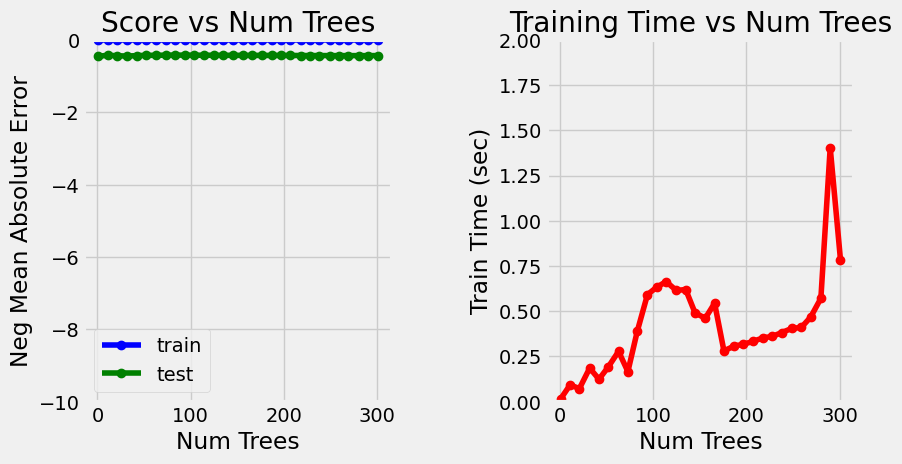

In [67]:
plot_results(tree_grid_search)

### Number of Features at Each Split

In [ ]:
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, train_features.shape[1] + 1))}

In [ ]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(final_model, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error')
feature_grid_search.fit(train_features, train_labels);

In [ ]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

## Visualizing One Tree in the Forest

My favorite part about the random forest in scikit-learn may be that you can actually look at any tree in the forest.
I'll pick one tree and visualize it as an image.

In [ ]:
# Use sklearn to export the tree
from sklearn.tree import export_graphviz

# Write the decision tree as a dot file
visual_tree = final_model.estimators_[12]
export_graphviz(visual_tree, out_file = 'images/best_tree.dot', feature_names = important_feature_names,
                precision = 2, filled = True, rounded = True, max_depth = None)

In [ ]:
# Use pydot for converting to an image file
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('images/best_tree.dot')
graph.write_png('images/best_tree.png')

True

![Best Tree](images/best_tree.png)